In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.post_processing.area_hulls import *
from amftrack.util.dbx import upload_folder
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.geometry import (
    distance_point_pixel_line,
    get_closest_line_opt,
    get_closest_lines,
    format_region,
    intersect_rectangle,
    get_overlap,
    get_bounding_box,
    expand_bounding_box,
    is_in_bounding_box,
    centered_bounding_box,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_hulls_skelet,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)

directory_targ = directory_project
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
# analysis_folders = analysis_info.loc[analysis_info['unique_id'].isin(plates)]

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
select = analysis_info.loc[analysis_info["Plate"] == "52"]

In [8]:
import pickle

path_exp = f'{directory_targ}{select["path_exp"].iloc[0]}'
exp = pickle.load(open(path_exp, "rb"))

In [9]:
load_graphs(exp, directory_targ, range(10), post_process=True)

In [16]:
import matplotlib.pyplot as plt

In [33]:
plt.rcParams["font.family"]

['sans-serif']

In [75]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Lucida Grande"]
fpath = Path(mpl.get_data_path(), "fonts/ttf/lucidasansdemibold.ttf")
from amftrack.pipeline.functions.image_processing.experiment_util import *


def plot_full(
    exp,
    t,
    region=None,
    edges=[],
    points=[],
    segments=[],
    nodes=[],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[(edge.begin.label + edge.end.label) % 255 for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )

    # 3/ Fusing layers
    fig = plt.figure(
        figsize=figsize
    )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
    ax = fig.add_subplot(111)
    ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=0.5, interpolation="none")

    # 3/ Plotting the Nodes
    size = node_size
    for node in nodes:
        c = f(list(node.pos(t)))
        color = make_random_color(node.label)[:3]
        reciprocal_color = 255 - color
        color = tuple(color / 255)
        reciprocal_color = tuple(reciprocal_color / 255)
        bbox_props = dict(boxstyle="circle", fc=color, edgecolor="none")
        if is_in_bounding_box(c, new_region):
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                bbox=bbox_props,
                font=fpath,
                fontdict={"color": reciprocal_color},
                size=size,
                # alpha = 0.5
            )
    # 4/ Plotting coordinates
    points = [f(c) for c in points]
    for i, c in enumerate(points):
        if is_in_bounding_box(c, new_region):
            plt.plot(c[1], c[0], marker="x", color="red", markersize=1, alpha=0.5)
            if with_point_label:
                plt.text(c[1], c[0], f"{i}")

    # 5/ Plotting segments
    segments = [[f(segment[0]), f(segment[1])] for segment in segments]
    for s in segments:
        plt.plot(
            [s[0][1], s[1][1]],  # x1, x2
            [s[0][0], s[1][0]],  # y1, y2
            color="white",
            linewidth=2,
        )

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    else:
        plt.show()

In [9]:
from amftrack.pipeline.functions.image_processing.experiment_util import *


def plot_full(
    exp: Experiment,
    t: int,
    region=None,
    edges: List[Edge] = [],
    points: List[coord_int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[(edge.begin.label + edge.end.label) % 255 for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )

    # 3/ Fusing layers
    fig = plt.figure(
        figsize=(36, 28)
    )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
    ax = fig.add_subplot(111)
    ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=0.5, interpolation="none")

    # 3/ Plotting the Nodes
    size = 1
    for node in nodes:
        color = make_random_color(node.label)[:3]
        reciprocal_color = 255 - color
        color = tuple(color / 255)
        reciprocal_color = tuple(reciprocal_color / 255)
        bbox_props = dict(boxstyle="circle", fc=color, edgecolor="none")

        c = f(list(node.pos(t)))
        if is_in_bounding_box(c, new_region):
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                size=size,
                bbox=bbox_props,
                color=reciprocal_color,
            )
    # 4/ Plotting coordinates
    points = [f(c) for c in points]
    for i, c in enumerate(points):
        if is_in_bounding_box(c, new_region):
            plt.plot(c[1], c[0], marker="x", color="red")
            if with_point_label:
                plt.text(c[1], c[0], f"{i}")

    # 5/ Plotting segments
    segments = [[f(segment[0]), f(segment[1])] for segment in segments]
    for s in segments:
        plt.plot(
            [s[0][1], s[1][1]],  # x1, x2
            [s[0][0], s[1][0]],  # y1, y2
            color="white",
            linewidth=2,
        )

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    return fig

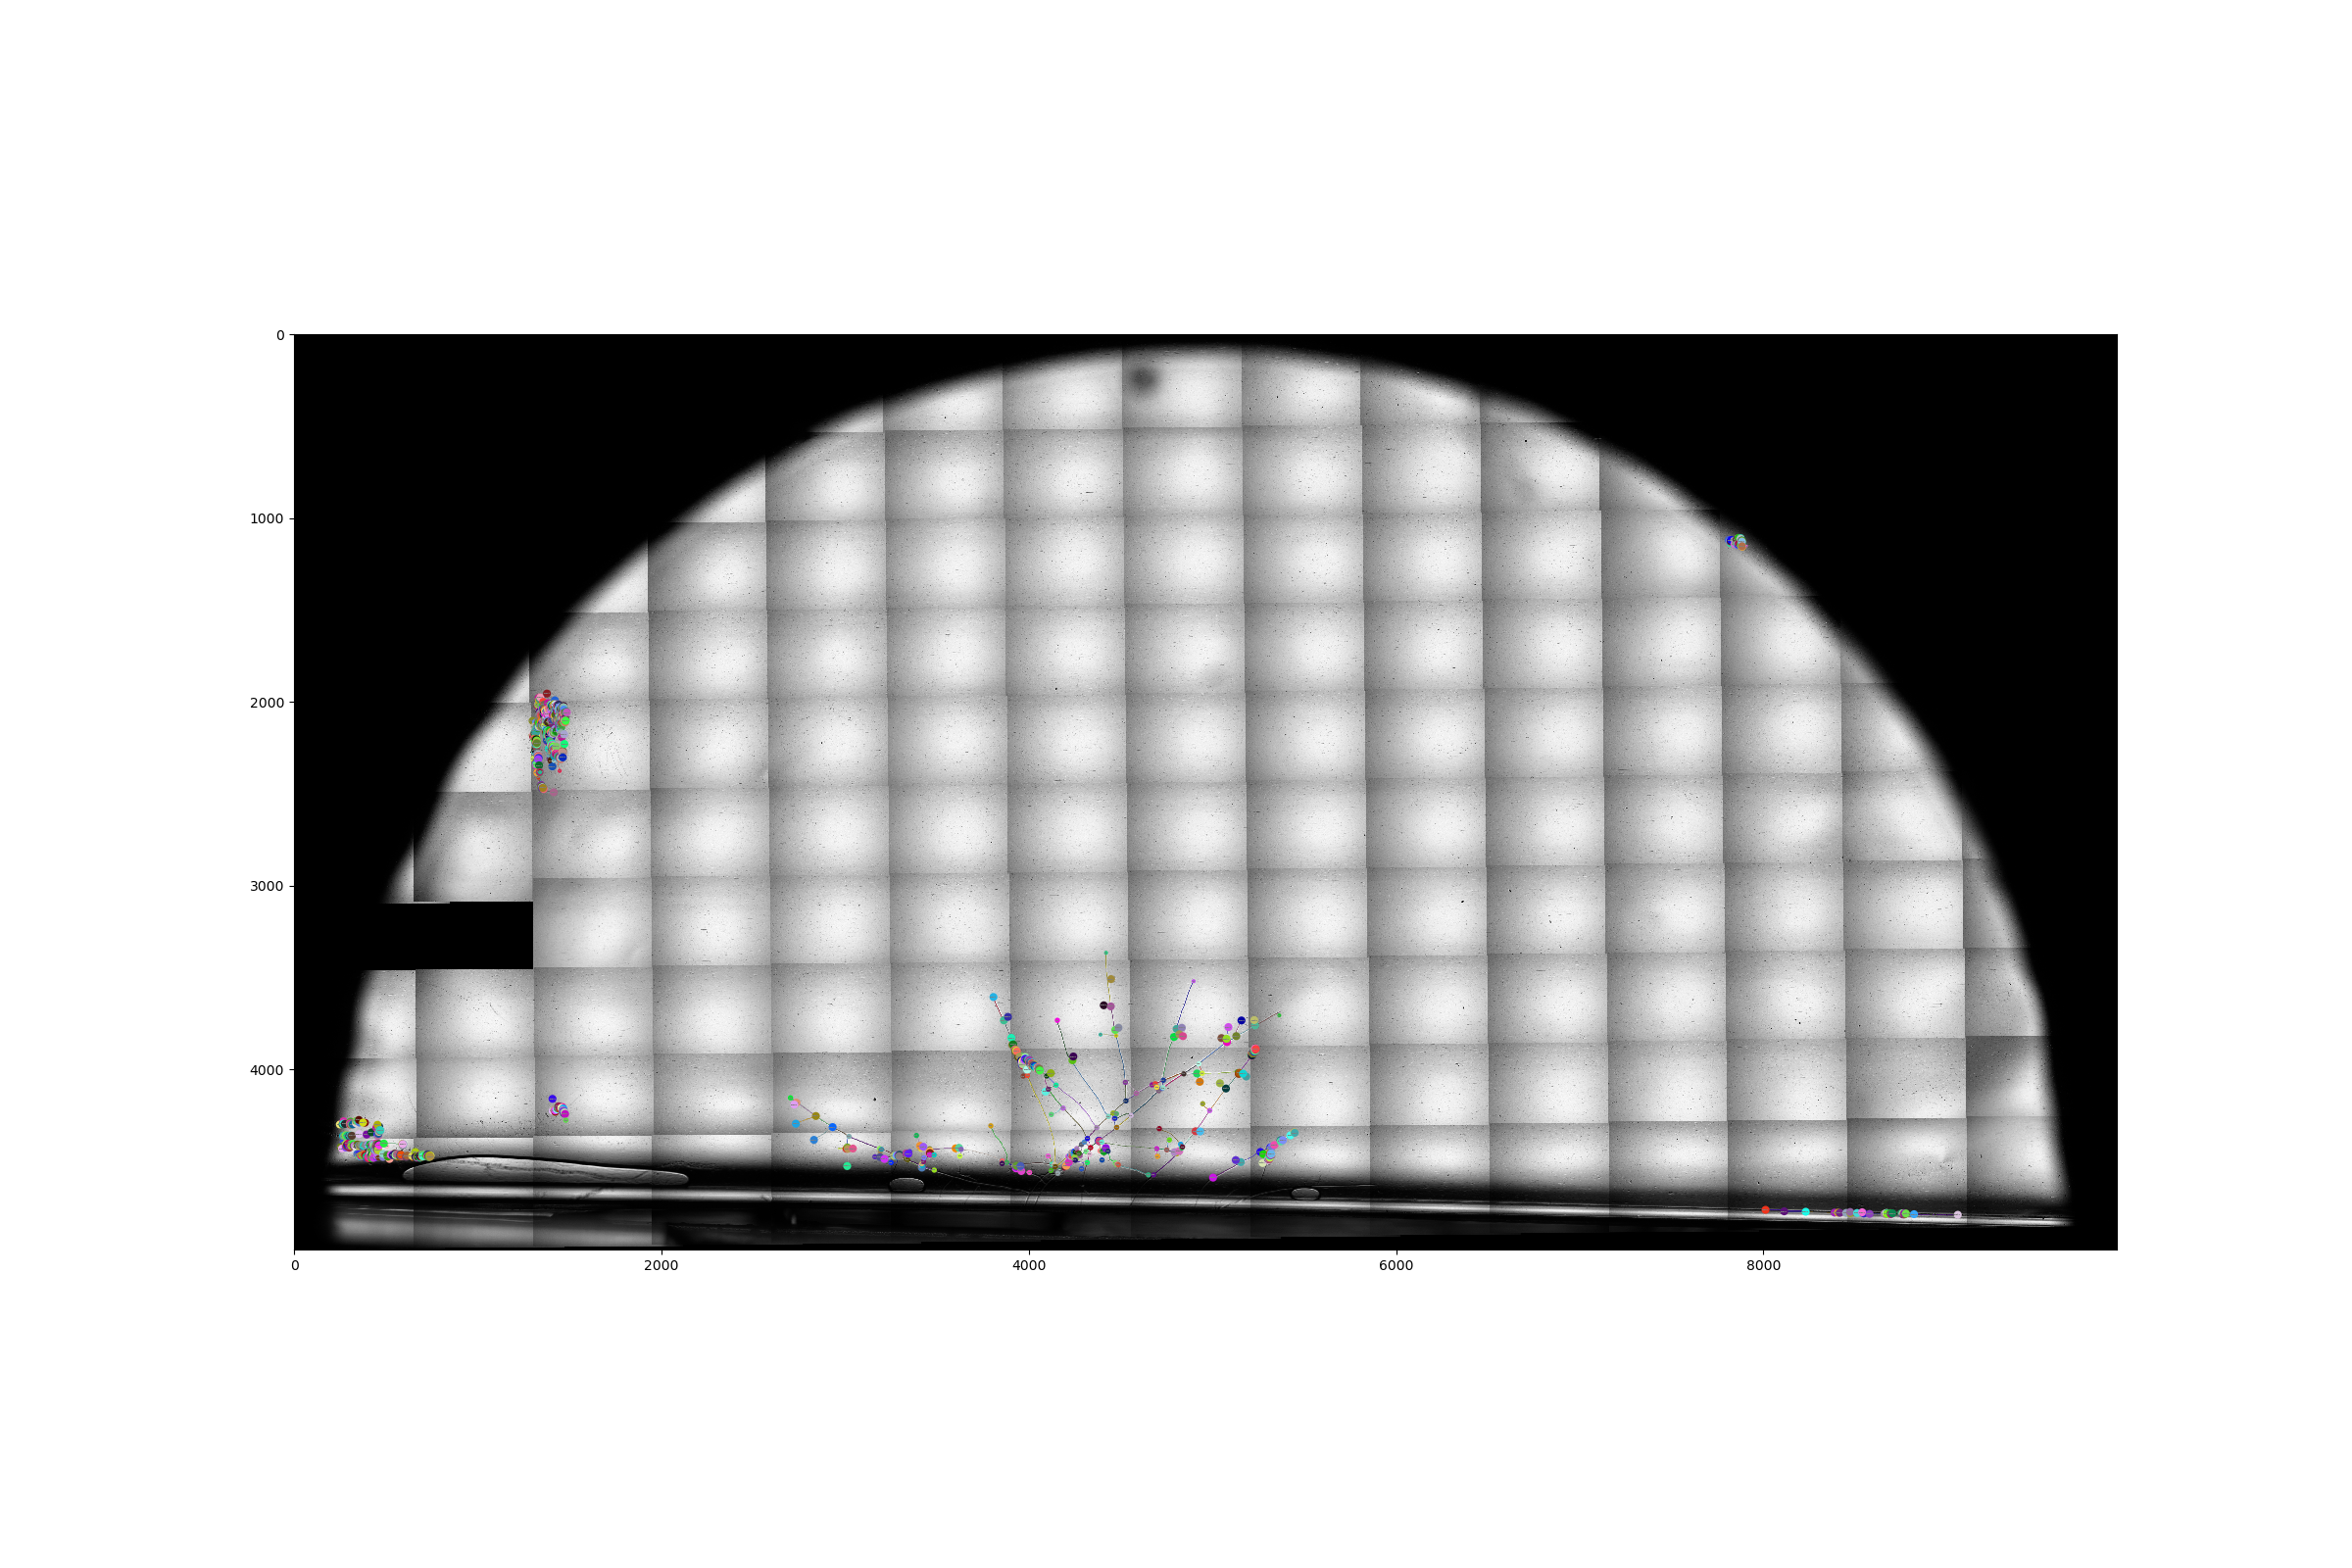

In [77]:
t = 6
exp.load_tile_information(t)

fig = plot_full(
    exp,
    t,
    # region=region,
    downsizing=5,
    nodes=[node for node in get_all_nodes(exp, t)],
    edges=get_all_edges(exp, t),
    # edges = [],
    dilation=4,
    prettify=False,
    figsize=(24, 16),
    dpi=400,
    node_size=1.5,
    save_path="test2.png",
)

Text(2, 3, 'text')

2022-09-26 10:30:07,229-[WARNING]- matplotlib.font_manager:1352 -> findfont: Font family ['Lucida'] not found. Falling back to DejaVu Sans.


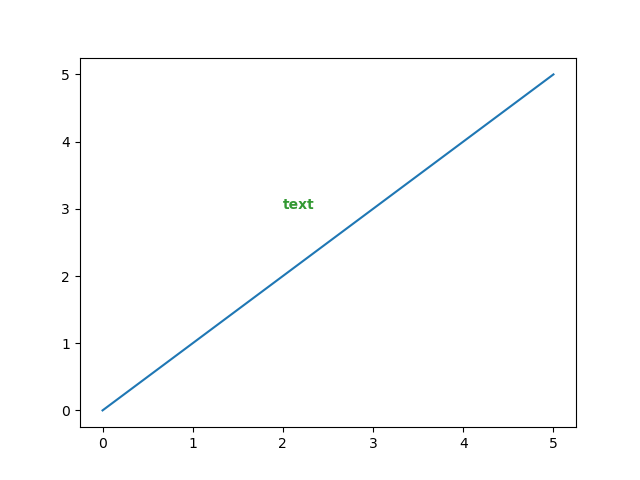

In [64]:
fix, ax = plt.subplots()
ax.plot((0, 5), (0, 5))
ax.text(
    2,
    3,
    "text",
    fontdict={"color": (0.2, 0.6, 0.2), "fontweight": "bold", "fontname": "Lucida"},
)

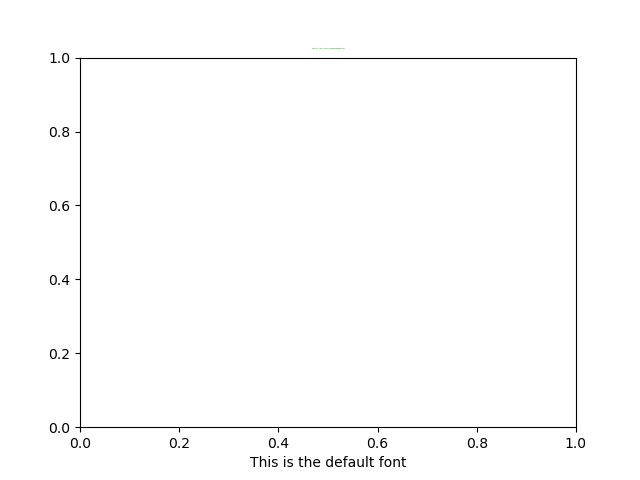

In [74]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title(
    f"This is a special font: {fpath.name}",
    font=fpath,
    fontdict={"color": (0.2, 0.6, 0.2), "fontweight": "bold", "fontname": "Lucida"},
    size=1,
)
ax.set_xlabel("This is the default font")

plt.show()

In [12]:
ends = [hypha for hypha in exp.hyphaes if len(hypha.ts) > 0]
to_choose = [hypha for hypha in ends if hypha.ts[0] < 100 and len(hypha.ts) > 4]

In [14]:
len(to_choose)

6947

In [15]:
tests = [
    hypha for hypha in exp.hyphaes if len(hypha.end.ts()) > 0 and hypha.end.ts()[0] < 10
]

In [16]:
t = 0
ends = [hypha.end for hypha in tests]

In [13]:
[len(end.ts()) for end in ends]

[7,
 73,
 149,
 59,
 111,
 149,
 45,
 149,
 149,
 149,
 149,
 149,
 9,
 60,
 200,
 176,
 15,
 19,
 19,
 149,
 149,
 36,
 10,
 6,
 5,
 10,
 155,
 149,
 33,
 18,
 149,
 68,
 148,
 6,
 11,
 148,
 15,
 149,
 148,
 147,
 5,
 8,
 13,
 142,
 88,
 84,
 145,
 4,
 10,
 30,
 151,
 145,
 4,
 7,
 7,
 5,
 144,
 146,
 30,
 172,
 6,
 12,
 47,
 143,
 143,
 128,
 143,
 12,
 6,
 134,
 7,
 5,
 22,
 169,
 142,
 142,
 27,
 142,
 4,
 6,
 4,
 6,
 78,
 18,
 144,
 5,
 5,
 46,
 7,
 170,
 140,
 140,
 24,
 9,
 26,
 14,
 140,
 4]

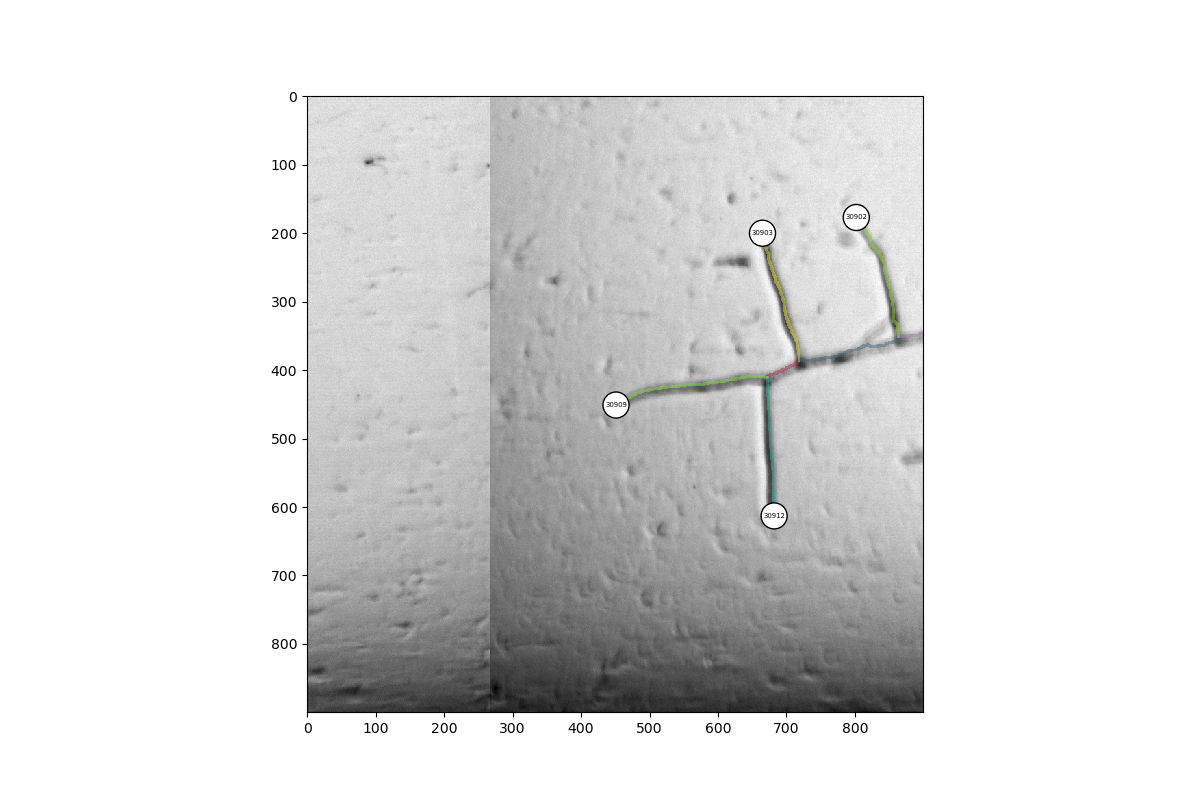

In [18]:
t = 5
exp.load_tile_information(t)
to_choose = [end for end in ends if end.is_in(t)]
node = choice(to_choose)
# node = hypha.end
pos = node.pos(t)
window = 600

region = centered_bounding_box(pos, size=int(1.5 * window))

plot_full(
    exp,
    t,
    region=region,
    downsizing=1,
    nodes=[
        node
        for node in ends
        if node.is_in(t) and np.linalg.norm(node.pos(t) - pos) <= window
    ],
    edges=get_all_edges(exp, t),
    # edges = [],
    dilation=4,
    prettify=False,
)

In [13]:
[end.label for end in ends]

[1,
 3,
 16,
 30,
 72,
 73,
 74,
 99,
 112,
 139,
 152,
 155,
 157,
 158,
 159,
 162,
 163,
 165,
 166,
 167,
 168,
 169,
 170,
 173,
 174,
 175,
 176,
 178,
 179,
 181,
 185,
 192,
 201,
 202,
 204,
 207,
 208,
 209,
 216,
 225,
 231,
 248,
 250,
 257,
 260,
 261,
 265,
 272,
 284,
 288,
 290,
 294,
 295,
 302,
 307,
 312,
 330,
 331,
 332,
 333,
 335,
 385,
 426,
 286043,
 286070,
 286080,
 286087,
 286089,
 286090,
 286097,
 286101,
 286102,
 286103,
 286104,
 286105,
 286147,
 549515,
 549521,
 549524,
 549525,
 549527,
 549534,
 549555,
 549557,
 549562,
 549563,
 549565,
 549566,
 549571,
 549572,
 549573,
 549574,
 549579,
 549581,
 549583,
 549590,
 549594,
 549603,
 549604,
 549644,
 554915,
 554917,
 554918,
 554922,
 554929,
 554931,
 554940,
 563525,
 563530,
 563546,
 563559,
 563565,
 563567,
 563580,
 563581,
 563585,
 563588,
 563589,
 563597,
 563601,
 563603,
 563609,
 563610,
 563611,
 563612,
 563613,
 563614,
 563615,
 563617,
 563621,
 563625,
 563626,
 563628,
 5

In [ ]:
time = "3:40:00"
list_f = [plot_hulls, plot_tracking]

list_args = [[]] * len(list_f)
overwrite = True
num_parallel = 30
run_parallel_post(
    "exp_plot.py",
    list_f,
    list_args,
    [directory, overwrite],
    analysis_folders,
    num_parallel,
    time,
    "global_plate_post_process",
    cpus=32,
    name_job="plotting",
    node="fat",
)

In [3]:
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.post_processing.exp_plot import *
from amftrack.pipeline.launching.run_super import run_parallel_post

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[
    analysis_info["Plate"].isin(["52", "1045", "1048", "84"])
]
# analysis_folders = analysis_info.loc[analysis_info['Plate'].isin(['52'])]

directory = directory_targ

In [8]:
directory

'/projects/0/einf914/data/'

In [11]:
analysis_folders

,folder_analysis,version,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,...,datetime,date_begin,date_end,number_timepoints,path_exp,path_global_hypha_info,path_time_hypha_info,path_time_plate_info,path_global_plate_info,date_run_analysis
13,Analysis_1048_20220506_200_Version1,Version1,/projects/0/einf914/data/20220506_2350_Plate03,1048,3,'Carrot','C2','001P100N100C','Y','-',...,2022-05-06 23:50:00,"06.05.2022, 23:50:","26.05.2022, 15:38:",200,Analysis_1048_20220506_200_Version1/experiment...,Analysis_1048_20220506_200_Version1/global_hyp...,Analysis_1048_20220506_200_Version1/time_hypha...,Analysis_1048_20220506_200_Version1/time_plate...,Analysis_1048_20220506_200_Version1/global_pla...,"01.01.1970, 01:00:"
16,Analysis_52_20220707_200_Version1,Version1,/scratch-shared/amftrack/stitch_temp2/20220707...,52,7,'Carrot','A5','001P100N100C','Y','-',...,2022-07-07 14:58:00,"07.07.2022, 14:58:","22.07.2022, 17:46:",155,Analysis_52_20220707_200_Version1/experiment.pick,Analysis_52_20220707_200_Version1/global_hypha...,Analysis_52_20220707_200_Version1/time_hypha_info,Analysis_52_20220707_200_Version1/time_plate_i...,Analysis_52_20220707_200_Version1/global_plate...,"01.01.1970, 01:00:"
25,Analysis_84_20220621_200_Version1,Version1,/scratch-shared/amftrack/stitch_temp2/20220621...,84,1,'Carrot','A5sp3','001P100N100C','Y','-',...,2022-06-21 15:21:00,"21.06.2022, 15:21:","06.07.2022, 08:05:",181,Analysis_84_20220621_200_Version1/experiment.pick,Analysis_84_20220621_200_Version1/global_hypha...,Analysis_84_20220621_200_Version1/time_hypha_info,Analysis_84_20220621_200_Version1/time_plate_i...,Analysis_84_20220621_200_Version1/global_plate...,"01.01.1970, 01:00:"
26,Analysis_1045_20220504_200_Version1,Version1,/projects/0/einf914/data/20220504_1900_Plate02,1045,2,'Carrot','C2','001P100N200C','Y','-',...,2022-05-04 19:00:00,"04.05.2022, 19:00:","25.05.2022, 05:52:",200,Analysis_1045_20220504_200_Version1/experiment...,Analysis_1045_20220504_200_Version1/global_hyp...,Analysis_1045_20220504_200_Version1/time_hypha...,Analysis_1045_20220504_200_Version1/time_plate...,Analysis_1045_20220504_200_Version1/global_pla...,"01.01.1970, 01:00:"


In [6]:
time = "24:00:00"
list_f = [plot_tracking]
list_f = [plot_anastomosis]
# list_f = [plot_blobs]

list_args = [[]] * len(list_f)

overwrite = True
num_parallel = 30
run_parallel_post(
    "exp_plot.py",
    list_f,
    list_args,
    [directory, overwrite],
    analysis_folders,
    num_parallel,
    time,
    "global_plate_post_process",
    cpus=32,
    name_job="plotting",
    node="fat",
)

Submitted batch job 1589964


sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 0.25 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.


In [5]:
time = "24:00:00"
list_f = [plot_hypha_track]
list_args = [[44132, 60034, 84, 72052, 71556, 104]]
overwrite = True
num_parallel = 30
run_parallel_post(
    "exp_plot.py",
    list_f,
    list_args,
    [directory, overwrite],
    analysis_folders,
    num_parallel,
    time,
    "global_plate_post_process",
    cpus=32,
    name_job="plotting",
    node="fat",
)

Submitted batch job 1572130


sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 0.25 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.
